In [10]:
import timm
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, batch_size, learning_rate, epoch):
        """ Generate a name for the model consisting of all the hyperparameter values

        Args:
            config: Configuration object containing the hyperparameters
        Returns:
            path: A string with the hyperparameter name and value concatenated
        """
        path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
        return path

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
num_countries = 6
batch_size = 32
lr = 0.001
num_epochs = 10

model = timm.create_model('efficientnet_b2', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.classifier.in_features, num_countries)
)
model = model.to(device)

In [14]:
transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
train_dataset = ImageFolder(root='data/train', transform=transform)
val_dataset = ImageFolder(root='data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [31]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss_array = np.zeros(num_epochs)
val_loss_array = np.zeros(num_epochs)

# training loop
for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    total = 0

    model.train()

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss_array[epoch] = train_loss/len(train_loader)
    
    train_acc = 100. * train_correct / total
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%")

    # validation
    val_loss = 0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss_array[epoch] = val_loss/len(val_loader)
    
    val_acc = 100. * val_correct / val_total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Save the current model (checkpoint) to a file
    model_path = get_model_name("efficientnet_b2", batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)

Epoch 1/10: 100%|██████████| 28/28 [03:26<00:00,  7.36s/it]


Train Loss: 0.1215, Train Accuracy: 97.62%
Validation Loss: 0.1167, Validation Accuracy: 96.59%


Epoch 2/10: 100%|██████████| 28/28 [04:02<00:00,  8.66s/it]


Train Loss: 0.0268, Train Accuracy: 99.10%
Validation Loss: 0.0220, Validation Accuracy: 98.63%


Epoch 3/10: 100%|██████████| 28/28 [05:33<00:00, 11.92s/it]


Train Loss: 0.0122, Train Accuracy: 99.55%
Validation Loss: 0.0203, Validation Accuracy: 98.63%


Epoch 4/10: 100%|██████████| 28/28 [03:58<00:00,  8.52s/it]


Train Loss: 0.0270, Train Accuracy: 99.10%
Validation Loss: 0.0275, Validation Accuracy: 98.98%


Epoch 5/10: 100%|██████████| 28/28 [02:16<00:00,  4.87s/it]


Train Loss: 0.0065, Train Accuracy: 99.77%
Validation Loss: 0.0279, Validation Accuracy: 98.63%


Epoch 6/10: 100%|██████████| 28/28 [02:20<00:00,  5.02s/it]


Train Loss: 0.0030, Train Accuracy: 99.89%
Validation Loss: 0.0182, Validation Accuracy: 99.32%


Epoch 7/10: 100%|██████████| 28/28 [02:42<00:00,  5.79s/it]


Train Loss: 0.0035, Train Accuracy: 99.89%
Validation Loss: 0.0168, Validation Accuracy: 99.32%


Epoch 8/10: 100%|██████████| 28/28 [02:40<00:00,  5.73s/it]


Train Loss: 0.0040, Train Accuracy: 99.77%
Validation Loss: 0.0187, Validation Accuracy: 99.66%


Epoch 9/10: 100%|██████████| 28/28 [02:20<00:00,  5.02s/it]


Train Loss: 0.0027, Train Accuracy: 99.89%
Validation Loss: 0.0183, Validation Accuracy: 99.66%


Epoch 10/10: 100%|██████████| 28/28 [02:34<00:00,  5.50s/it]


Train Loss: 0.0021, Train Accuracy: 99.89%
Validation Loss: 0.0169, Validation Accuracy: 99.66%


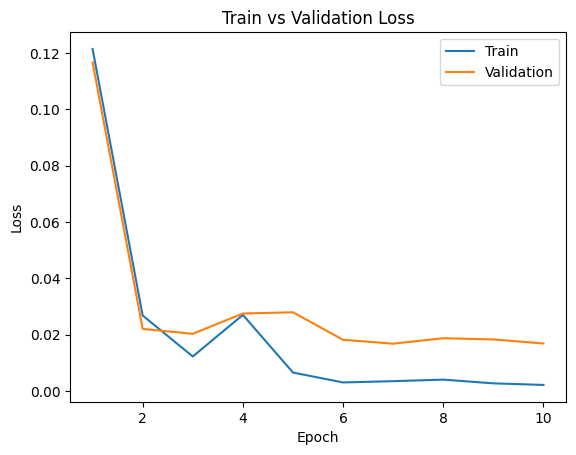

In [33]:
# Write the train/test loss/err into CSV file for plotting later
epoch = np.arange(1, num_epochs+1)
np.savetxt("{}_train_loss.csv".format(model_path), train_loss_array)
np.savetxt("{}_val_loss.csv".format(model_path), val_loss_array)
netPath = get_model_name("efficientnet_b2", batch_size, lr, num_epochs-1)
plot_training_curve(netPath)